# Evaluate Performance 📝

### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
import pickle
import multiprocessing as mp
import re
import matplotlib as mpl

### Define constants

In [3]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
EVALUATIONS = 'evaluations'
HOP_SEC = 512 * 1 / 22050
N_CORES = mp.cpu_count()
RESULTS = 'results'
Path(RESULTS).mkdir(parents=True, exist_ok=True)

## 1. Evaluate an experiments directory

Fill in the following parameters to evaluate. This will compute 

In [4]:
DATA = "test_full"
EXPERIMENTS = 'experiments_test'
ALGOS = ['DTW1', 'DTW2', 'DTW3', 'DTW4', 'DTW5', 'DTW1_add3', 'DTW1_add4', 'DTW2_downsampleQuantized', 'DTW2_downsampleInterpolate', 'DTW2_upsampleQuantized', 'DTW2_upsampleInterpolate', 'adaptiveWeight1', 'adaptiveWeight2', 'selectiveTransitions2','selectiveTransitions3','selectiveTransitions4','selectiveTransitions5']
TOLERANCES = [100, 200, 500]

In [277]:
def get_timestamps(annotfile, subseq=False, offset=None, length=None):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    timestamps = np.array(df[0])
    if subseq:
        return timestamps, int(df[2][0].split("-")[-1]), len(timestamps)
    if offset:
        return timestamps[offset:offset+length], None, None
    return timestamps, None, None

def eval_file(align_file, annotation_root1, annotation_root2):

    piece1, piece2 = os.path.basename(align_file).split('__') # ['Chopin_Op017No4_Fou-1978_pid9071-20', 'Chopin_Op017No4_Magaloff-1977_pid5667267b-10.pkl']
    mazurka = '_'.join(os.path.basename(piece1).split('_')[0:2]) # Chopin_Op017No4
    annotation1 = (Path(annotation_root1) / mazurka / piece1).with_suffix('.beat') # median_x2.000/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Fou-1978_pid9071-20.beat
    annotation2 = (Path(annotation_root2) / mazurka / piece2).with_suffix('.beat') # median_x0.500/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Magaloff-1977_pid5667267b-10.beat

    # check if first annotation file is a subsequence file
    subseq = True if "subseq20" in str(annotation1) else False
    t1, offset, length = get_timestamps(annotation1, subseq, None, None)
    t2, _, _ = get_timestamps(annotation2, False, offset, length)

    path = pd.read_pickle(align_file) # obtain path from DTW algorithm
    # at each ground truth beat timestamp in B, project to predicted timestamp in A and subtract from ground truth timestamp in A
    return [] if path is None else np.interp(t2, path[1,:] * HOP_SEC, path[0,:] * HOP_SEC) - t1

def eval_dir(hypdir, querylist, annotation_root1, annotation_root2, savefile):
    all_errs = {}
    with open(querylist, 'r') as f:
        for line in f:
            piece1, piece2 = line.strip().split() # Chopin_Op017No4/Chopin_Op017No4_Fou-1978_pid9071-20, Chopin_Op017No4/Chopin_Op017No4_Magaloff-1977_pid5667267b-10
            pair = os.path.basename(piece1) + '__' + os.path.basename(piece2) # Chopin_Op017No4_Fou-1978_pid9071-20__Chopin_Op017No4_Magaloff-1977_pid5667267b-10
            align_file = hypdir + '/' + pair + '.pkl' # experiments_toy/DTW1_add4_x2.000_x0.500/Chopin_Op017No4_Fou-1978_pid9071-20__Chopin_Op017No4_Magaloff-1977_pid5667267b-10.pkl
            if os.path.exists(align_file):
                all_errs[pair] = eval_file(align_file, annotation_root1, annotation_root2)
    if savefile:
        pickle.dump(all_errs, open(savefile, 'wb'))

def eval_all_dirs(rootdir, data, outdir):
    inputs = []
    for hypdir in os.listdir(rootdir):
        savefile = outdir + '/' + data + '.' + os.path.basename(hypdir) + '.pkl'
        info = hypdir.split('_')
        subseq, piece1, piece2 = info[-3], info[-2], info[-1]
        subseq = "_subseq20" if "sub" in subseq else ""
        annotation_root1 = f'median_{piece1}{subseq}/annotations_beat'
        annotation_root2 = f'median_{piece2}/annotations_beat'
        inputs.append((rootdir + '/' + hypdir, Path(f'cfg_files/{data}.txt'), annotation_root1, annotation_root2, savefile))
    return inputs

Here are the estimated runtimes for each data partition:

`train_toy`: 1 sec

`train_small`: 5 secs

`train_medium`: 13 mins

`train_full`: 17 mins

`test_full`: 25 mins

In [278]:
Path(EVALUATIONS).mkdir(parents=True, exist_ok=True)
inputs = eval_all_dirs(EXPERIMENTS, DATA, EVALUATIONS)
with mp.Pool(processes = N_CORES) as pool:
    pool.starmap(eval_dir, inputs)

## 2. Calculate errors for each evaluation file

In [279]:
def get_eval_folders(data, algorithms):
    """
    Return a list of evaluation directories given a data type and list of algorithms.
    """
    return [(f'{data}.{algorithm}_{warp1}_{warp2}') for algorithm in algorithms
            for warp1, warp2 in [('x1.000', 'x1.000'), ('x1.260', 'x1.000'), ('x1.260', 'x0.794'),
                ('x1.588', 'x0.794'), ('x1.588', 'x0.630'), ('x2.000', 'x0.630'), ('x2.000', 'x0.500')]]

def calc_error_rates(eval_dir, x):

    err_file = EVALUATIONS + '/' + eval_dir + '.pkl'
    algo, warp1, warp2 = re.search("^\w+_\w+\.(.+)_x(\d.\d{3})_x(\d.\d{3})$", eval_dir).group(1,2,3)
    
    with open(err_file, 'rb') as f:
        err_dict = pickle.load(f)
    
    errs = [err for errs in err_dict.values() for err in errs]
    
    return algo, warp1, warp2, errs

In [280]:
eval_dirs = get_eval_folders(DATA, ALGOS)
inputs = [(dir, None) for dir in eval_dirs]

with mp.Pool(processes = N_CORES) as pool:
    results = pool.starmap(calc_error_rates, inputs)

## 3. Create dataframe

In [281]:
res = []
for algo, warp1, warp2, errs in results:

    global_time_warp = round(float(warp1)/float(warp2), 3)

    err_rates = []
    for tolerance in TOLERANCES:
        adj_tolerance = tolerance * float(warp1)
        err_rates.append(np.mean(np.abs(errs) > (adj_tolerance / 1000)) * 100)

    res.append((algo, global_time_warp, err_rates[0], err_rates[1], err_rates[2]))
    
df = pd.DataFrame(res, columns = ["algorithm", "global_time_warp", "error_100", "error_200", "error_500"])

In [282]:
df.head()

,algorithm,global_time_warp,error_100,error_200,error_500
0,DTW1,1.000,22.119274,10.355498,3.333719
1,DTW1,1.260,21.153332,9.806035,3.416976
2,DTW1,1.587,24.520487,13.376266,6.882070
3,DTW1,2.000,96.154043,92.430462,81.914511
4,DTW1,2.521,100.000000,100.000000,100.000000


### Save dataframe to `results` directory

In [283]:
df.to_csv(f"{RESULTS}/{DATA}_results.csv", index=False)

## 3. Visualize grouped barplots

In [7]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['figure.figsize'] = [12, 5]
mpl.rcParams['savefig.pad_inches'] = 0
plt.style.use("ggplot")

def plot_grouped_barplot(df, tols=False):
    
    if tols:
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.barplot(data=df, x="global_time_warp", y="error_200", hue="algorithm", palette="Paired", ax=ax)
        for ix, a in enumerate(ax.patches):
            x_start = a.get_x()
            width = a.get_width()
            ax.plot([x_start, x_start+width], 2*[df.loc[ix, 'error_100']], '-', c='k')
            ax.plot([x_start, x_start+width], 2*[df.loc[ix, 'error_500']], '-', c='k')
    else:
        sns.barplot(data=df, x="global_time_warp", y="error_200", hue="algorithm", palette="Paired")

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Global Time Warp", size=14)
    plt.ylabel("Error Rate", size=14)
    plt.legend(bbox_to_anchor=(1, 1), fontsize=12, loc=2, fancybox=True, borderpad=0.8, labelspacing=0.4, borderaxespad=1.8, framealpha=0.7, facecolor='white')
    plt.grid(linestyle = '--', linewidth = 1)
    plt.show()

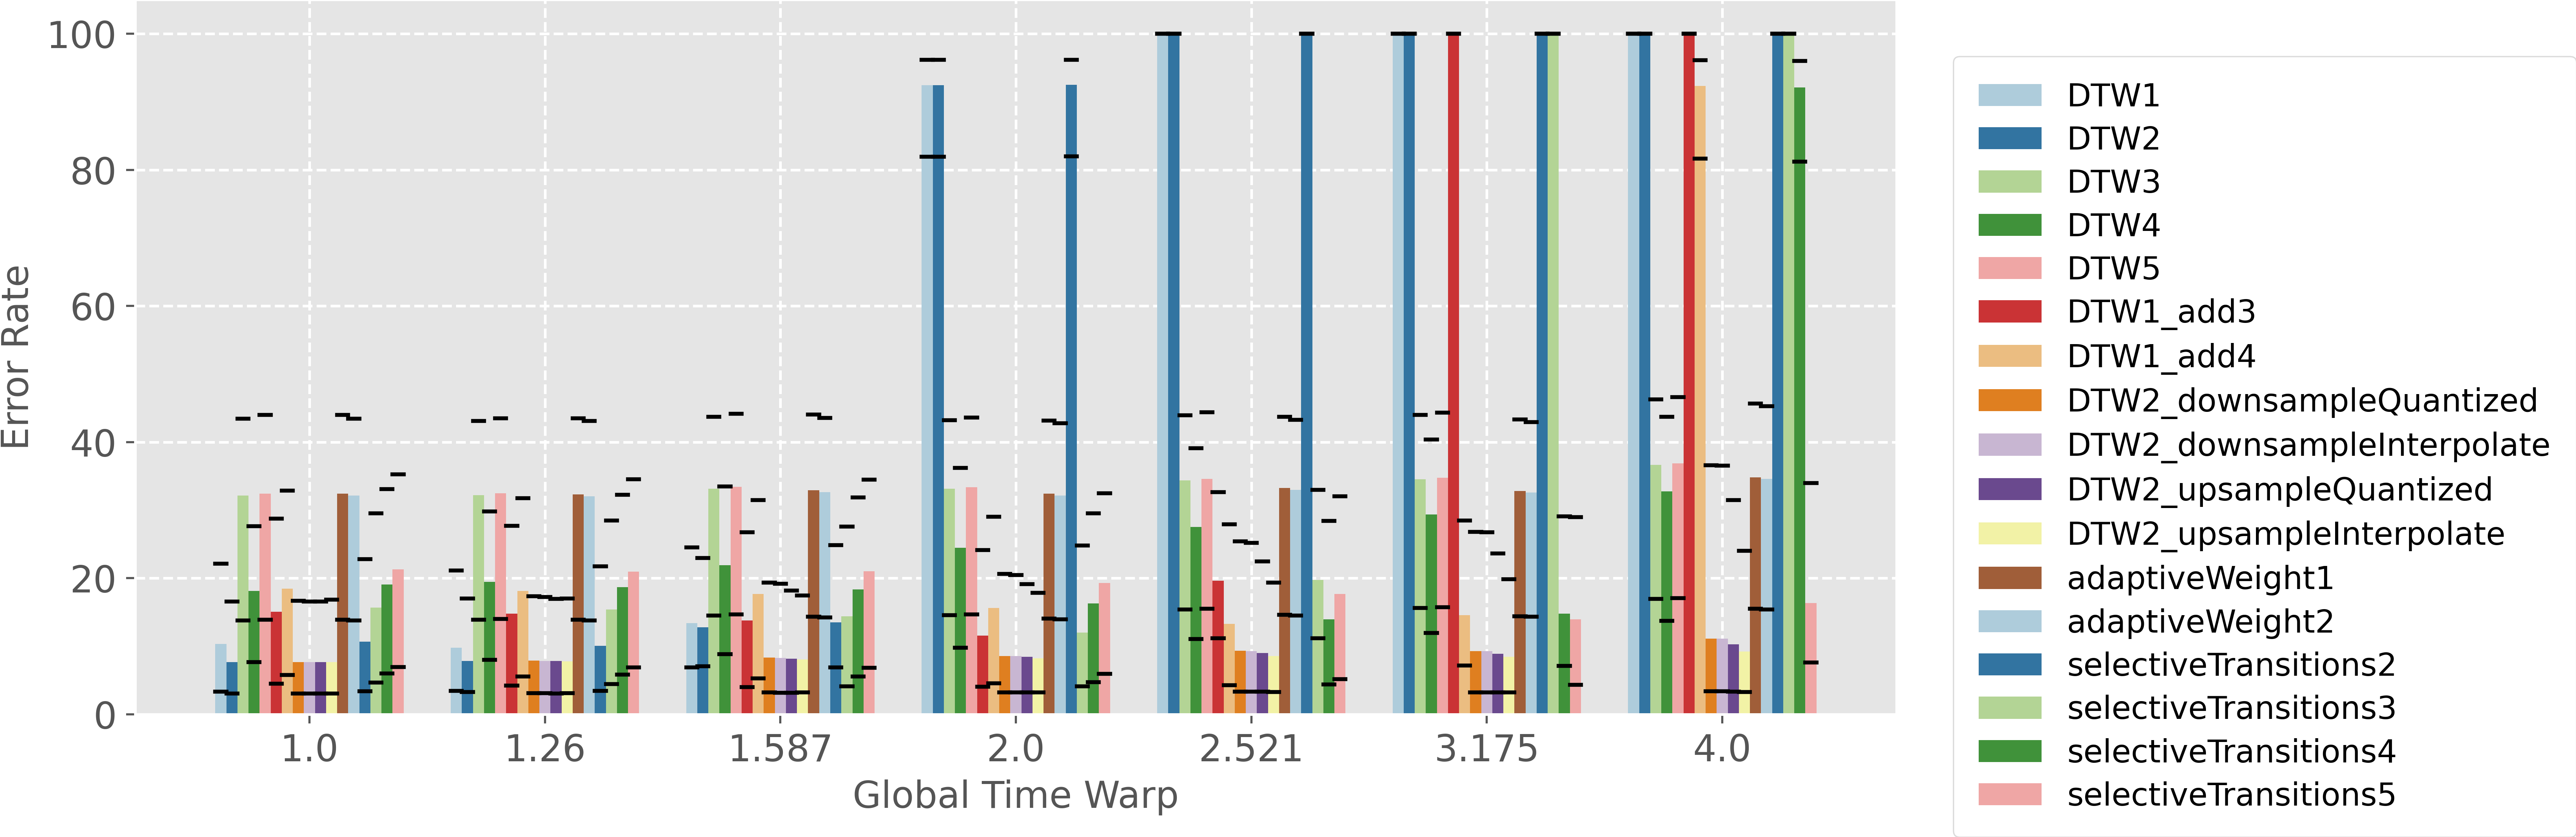

In [9]:
df = pd.read_csv(f"{RESULTS}/{DATA}_results.csv")
plot_grouped_barplot(df, True)

In [15]:
# def plot_multiple_roc(errRates, basenames):
#     numSystems = errRates.shape[0]
#     maxTol = errRates.shape[1] - 1
#     for i in range(numSystems):
#         plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
        
#     # create appropriate legend names corresponding to basenames
#     legend = []
#     for folder in basenames:
#         system, global_time_warp = get_info_from_basename(folder)
#         legend.append('Global Time Warp = {}, {}'.format(global_time_warp, system))
    
#     plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
#     plt.xlabel('Error Tolerance (ms)')
#     plt.ylabel('Error Rate (%)')
#     plt.show()
#     return

# plot_multiple_roc(errRates, toPlot)